# 종목 확인

In [94]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from pathlib import Path

from tqdm import tqdm


plt.rc('font', family='Malgun Gothic')


In [95]:
CWD_PATH = Path.cwd()
DATA_PATH = CWD_PATH / 'data'
OUTPUT_PATH = CWD_PATH / 'output'

In [96]:
data_df = pd.read_parquet(OUTPUT_PATH / 'option_data_targets_20220101-20241204.parquet')

In [97]:
udly_cols = [
    'trade_date',
    'underlying_full',
    # 'udly_open',
    # 'udly_high',
    # 'udly_low',
    # 'udly_close',
    # 'udly_volume',
    'udly_return',   
]

In [98]:
data_df = data_df[udly_cols].drop_duplicates().sort_values('trade_date').reset_index(drop=True)

In [99]:
data_df = data_df.pivot_table(index='trade_date', columns='underlying_full', values='udly_return')
# data_df = data_df.pivot_table(index='trade_date', columns='underlying_full', values='udly_close')

In [100]:
# relative_price = data_df / data_df.iloc[0]
# relative_price.plot(figsize=(20, 10))

In [102]:
VOL_WINDOW = 126 # 6 months

vol_df = data_df.rolling(window=VOL_WINDOW).std() * np.sqrt(252) # annualized

In [103]:
START_DATE = '2024-05-02'

vol_df = vol_df.loc[START_DATE:, :]

In [104]:
vol_df.columns

Index(['KT', 'LG디스플레이', 'LG생활건강우', 'LG에너지솔루션', 'LG전자', 'LG화학', 'NAVER',
       '삼성에스디에스', '삼성전기', '삼성전자', '아모레퍼시픽우', '카카오', '한국항공우주', '현대모비스', '현대제철'],
      dtype='object', name='underlying_full')

In [105]:
# 6개월 데이터 없는 놈들 drop 

MAX_NAN_ALLOWED = 10

vol_df = vol_df.dropna(thresh=len(vol_df) - MAX_NAN_ALLOWED, axis=1)

relative_vol_df = vol_df / vol_df.iloc[0]

In [106]:
# Melt the dataframe for easier plotting in Plotly
melted_df = relative_vol_df.reset_index().melt(id_vars=relative_vol_df.index.name, var_name='Stock', value_name='Price')
melted_df.rename(columns={'index': 'Date'}, inplace=True)


In [107]:
melted_df

,trade_date,Stock,Price
0,2024-05-02,LG화학,1.000000
1,2024-05-03,LG화학,0.998516
2,2024-05-07,LG화학,0.997807
3,2024-05-08,LG화학,0.995087
4,2024-05-09,LG화학,0.973838
...,...,...,...
1010,2024-11-28,현대제철,0.983567
1011,2024-11-29,현대제철,1.003512
1012,2024-12-02,현대제철,1.002787
1013,2024-12-03,현대제철,1.015836


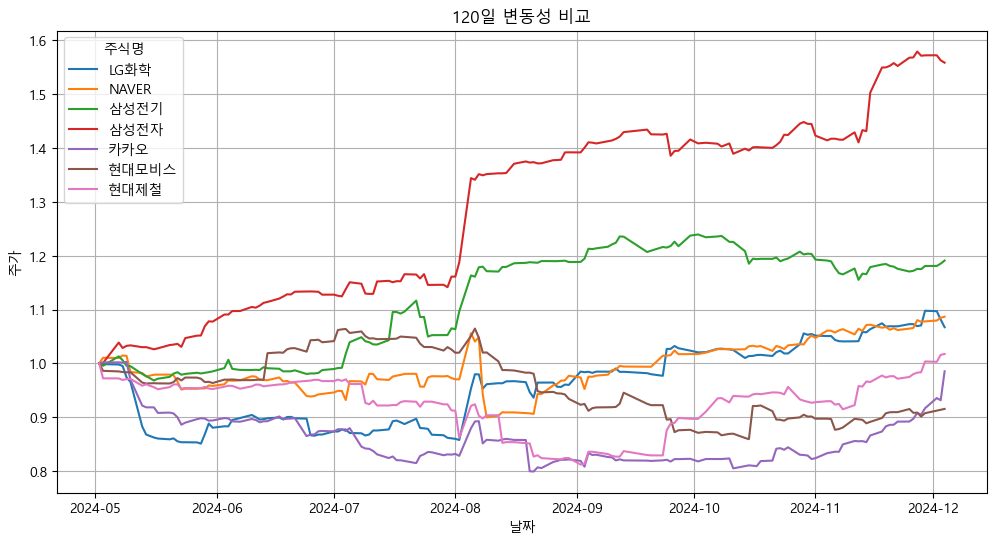

In [145]:
plt.figure(figsize=(12, 6))

for stock in melted_df['Stock'].unique():
    stock_data = melted_df[melted_df['Stock'] == stock]
    plt.plot(stock_data['trade_date'], stock_data['Price'], label=stock)

# Customize the plot
plt.title('120일 변동성 비교')
plt.xlabel('날짜')
plt.ylabel('주가')
plt.legend(title='주식명')
plt.grid()

plt.show()

In [148]:
current_vol_rank = vol_df.iloc[-1].sort_values(ascending=False)
current_vol_rank = pd.DataFrame(current_vol_rank).reset_index()
current_vol_rank.columns = ['Stock', '120d vol']
current_vol_rank['rank'] = current_vol_rank['120d vol'].rank(ascending=False)
current_vol_rank


,Stock,120d vol,rank
0,LG화학,0.413809,1.0
1,카카오,0.368044,2.0
2,삼성전자,0.363183,3.0
3,삼성전기,0.357987,4.0
4,현대제철,0.321901,5.0
5,NAVER,0.321512,6.0
6,현대모비스,0.306376,7.0


In [113]:
vol_valid_stocks = vol_df.columns

In [114]:
ret_df = data_df.loc[START_DATE:, :]

ret_df = ret_df[vol_valid_stocks]

cumret_df = (1 + ret_df).cumprod()

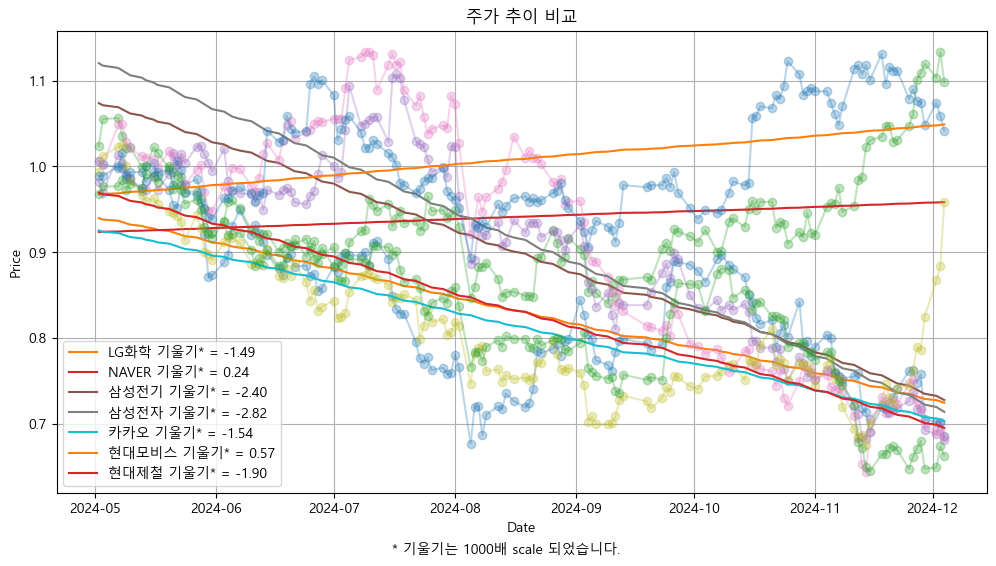

In [137]:
def plot_regression_trends(price_data):
    plt.figure(figsize=(12, 6))

    for stock_id in price_data.columns:
        prices = price_data[stock_id]
        x = np.arange(len(prices))  # x-axis as sequential integers for regression
        
        # Fit a linear regression model (y = mx + b)
        m, b = np.polyfit(x, prices, 1)
        
        # Generate regression line
        trend_line = m * x + b
        
        # Plot original prices and regression trend
        plt.plot(price_data.index, prices, marker='o', alpha=0.3)
        plt.plot(price_data.index, trend_line, linestyle='-', label=f'{stock_id} 기울기* = {1000 * m:.2f}')

    # Customize the plot
    plt.title('주가 추이 비교')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    
    plt.figtext(0.5, 0.01, "* 기울기는 1000배 scale 되었습니다.", ha="center", fontsize=10)

    # Show the plot
    plt.show()

# Call the function with the price data
plot_regression_trends(cumret_df)

In [152]:
import pandas as pd
import numpy as np

# Calculate the slope for each stock in cumret_df
def calculate_slopes(price_data):
    slopes = {}
    for stock_id in price_data.columns:
        prices = price_data[stock_id]
        x = np.arange(len(prices))  # x-axis as sequential integers for regression
        m, _ = np.polyfit(x, prices, 1)  # Only need the slope (m)
        slopes[stock_id] = m
    return slopes

# Get slopes and create a DataFrame with ranks
slopes = calculate_slopes(cumret_df)
slopes_df = pd.DataFrame.from_dict(slopes, orient='index', columns=['Slope'])
slopes_df['Rank'] = slopes_df['Slope'].rank(ascending=False).astype(int)

# Sort the DataFrame by rank
slopes_df = slopes_df.sort_values(by='Rank')

slopes_df.reset_index(inplace=True)
slopes_df


,index,Slope,Rank
0,현대모비스,0.000565,1
1,NAVER,0.000242,2
2,LG화학,-0.001494,3
3,카카오,-0.001544,4
4,현대제철,-0.001904,5
5,삼성전기,-0.002403,6
6,삼성전자,-0.002823,7


In [155]:
agg_rank = pd.merge(current_vol_rank, slopes_df, left_on='Stock', right_on='index', how='inner')
agg_rank.drop(columns='index', inplace=True)

In [157]:
agg_rank['high_vol?'] = agg_rank['120d vol'] > agg_rank['120d vol'].median()
agg_rank['high_slope?'] = agg_rank['Slope'] > agg_rank['Slope'].median()

In [159]:
agg_rank['vol_slope_case'] = agg_rank['high_vol?'].astype(int) * 2 + agg_rank['high_slope?'].astype(int)

In [161]:
agg_rank.sort_values('vol_slope_case', ascending=False)

,Stock,120d vol,rank,Slope,Rank,high_vol?,high_slope?,vol_slope_case
0,LG화학,0.413809,1.0,-0.001494,3,True,True,3
1,카카오,0.368044,2.0,-0.001544,4,True,False,2
2,삼성전자,0.363183,3.0,-0.002823,7,True,False,2
5,NAVER,0.321512,6.0,0.000242,2,False,True,1
6,현대모비스,0.306376,7.0,0.000565,1,False,True,1
3,삼성전기,0.357987,4.0,-0.002403,6,False,False,0
4,현대제철,0.321901,5.0,-0.001904,5,False,False,0


c:\Users\chlje\VSCodeProjects\KAIST_MFE\.venv\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from current font.



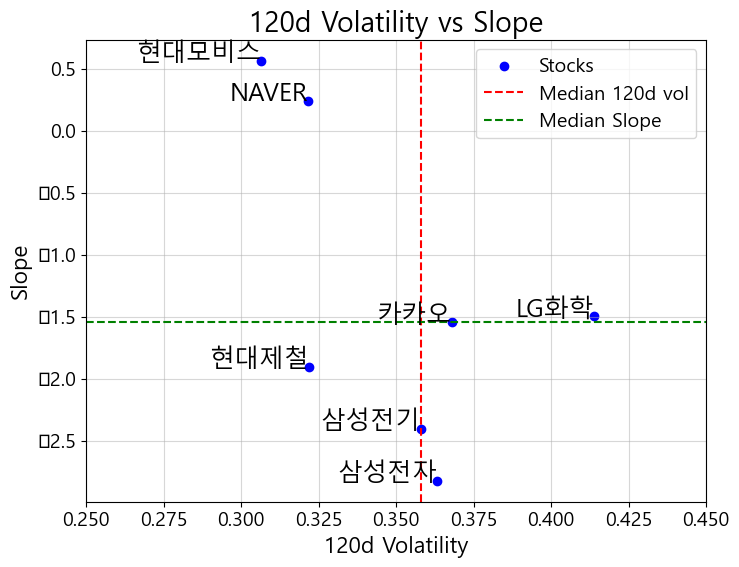

In [164]:
df = agg_rank

df['Slope'] = 1000 * df['Slope']  # Scale the slope for better visualization

# Calculate medians for "120d vol" and "Slope"
median_vol = df["120d vol"].median()
median_slope = df["Slope"].median()

# Adjusting the font size and fixing the x-axis range
plt.figure(figsize=(8, 6))
plt.scatter(df["120d vol"], df["Slope"], color="blue", label="Stocks")

# Add labels to points with increased font size
for i, stock in enumerate(df["Stock"]):
    plt.text(df["120d vol"][i], df["Slope"][i], stock, fontsize=18, ha="right")

# Add median lines
plt.axvline(median_vol, color="red", linestyle="--", label="Median 120d vol")
plt.axhline(median_slope, color="green", linestyle="--", label="Median Slope")

# Customize the plot with larger font sizes and fixed x-axis range
plt.title("120d Volatility vs Slope", fontsize=20)
plt.xlabel("120d Volatility", fontsize=16)
plt.ylabel("Slope", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(alpha=0.5)
plt.xlim(0.25, 0.45)  # Fix x-axis range

# Show plot
plt.show()

In [167]:
SELECTION = [
    '삼성전자',
    '현대모비스',
    'NAVER',
    '카카오'
]

<Axes: title={'center': '선정된 종목들의 주가 추이 (상대가격)'}, xlabel='trade_date'>

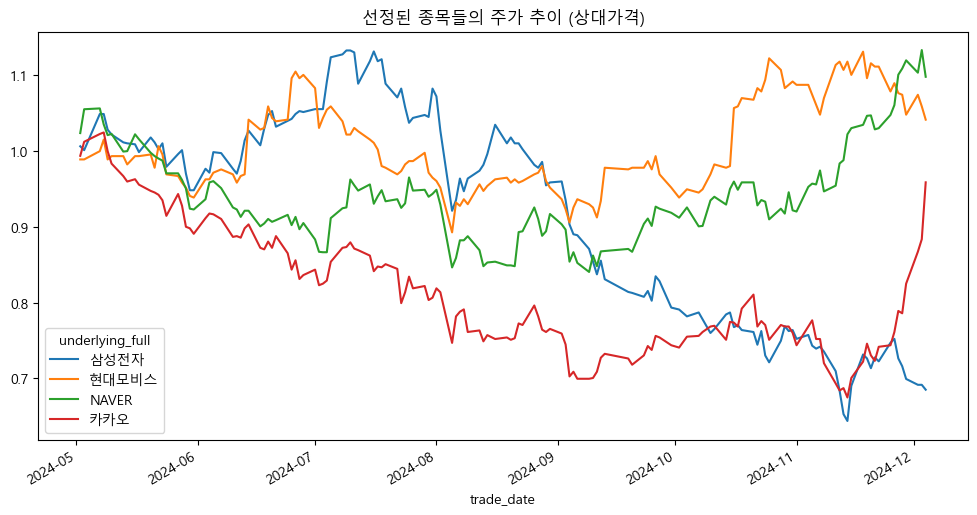

In [171]:
cumret_df[SELECTION].plot(figsize=(12, 6), title='선정된 종목들의 주가 추이 (상대가격)')

In [179]:
start_vol = vol_df[SELECTION].iloc[0] # annualized
start_vol.round(2)

underlying_full
삼성전자     0.23
현대모비스    0.33
NAVER    0.30
카카오      0.37
Name: 2024-05-02 00:00:00, dtype: float64

In [178]:
end_vol = vol_df[SELECTION].iloc[-1]
end_vol.round(2)

underlying_full
삼성전자     0.36
현대모비스    0.31
NAVER    0.32
카카오      0.37
Name: 2024-12-04 00:00:00, dtype: float64